## Import Dependencies

In [1]:
import torch
import torchaudio
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics

import os
from pathlib import Path

/home/colin/elec5305/ele5305_research_project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration 

In [2]:
### DO NOT CHANGE UNLESS RE-GENERATING DATASET IMAGES ###
class Config_Mel():
    def __init__(self) -> None:
        
        # Device
        self.device = 'cpu'
        
        # Dataset Path
        self.birdclef2023 = 'birdclef-2023'

        # Out path
        self.outpath_images = self.birdclef2023 + '_MelSpectrograms'

        self.melSpecTransform = torchaudio.transforms.AmplitudeToDB()

        # Audio Features
        self.sample_rate = 32000
        self.n_fft=2048
        self.f_min=40
        self.f_max=15000
        self.hop_length=512
        self.n_mels=128
        self.mel_args = {'sample_rate': self.sample_rate,
                         'n_fft': self.n_fft,
                         'f_min': self.f_min,
                         'f_max': self.f_max,
                         'hop_length': self.hop_length,
                         'n_mels': self.n_mels}
### DO NOT CHANGE UNLESS RE-GENERATING DATASET IMAGES ###

class Config():
    def __init__(self) -> None:

        self.run_environment = 'local' # 'kaggle' 'local' 'colab'

        # Device
        if (self.run_environment == 'kaggle') or (self.run_environment == 'colab'):
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        
        # Dataset Path
        if self.run_environment == 'kaggle':
            self.soundscape_paths = "/kaggle/input/birdclef-2023/test_soundscapes"
        elif self.run_environment == 'local':
            self.soundscape_paths = '/home/colin/elec5305/ele5305_research_project/birdclef-2023/test_soundscapes'
        elif self.run_environment == 'colab':
            raise NotImplementedError
        
        # Metadata Path
        if self.run_environment == 'kaggle':
            self.metadata_path = '/kaggle/input/birdclef-2023/train_metadata.csv'
        elif self.run_environment == 'local':
            self.metadata_path = '/home/colin/elec5305/ele5305_research_project/birdclef-2023/train_metadata.csv'
        elif self.run_environment == 'colab':
            raise NotImplementedError

        # Out path
        if self.run_environment == 'kaggle':
            self.outpath = '/kaggle/working/'
        elif self.run_environment == 'local':
            self.outpath = '/home/colin/elec5305/ele5305_research_project/src_mel/results'
        elif self.run_environment == 'colab':
            self.outpath = ''

        # Dataloader options
        self.num_workers = 2
        self.test_batch_size = 64

        # Model name
        self.model_name = 'tf_efficientnet_b0_ns'

        # Weights path
        if self.run_environment == 'kaggle':
            self.pretrained_weights = '/kaggle/input/weigths/model_weights.pth'
        elif self.run_environment == 'local':
            self.pretrained_weights = '/home/colin/elec5305/ele5305_research_project/src_mel/weights/model_weights.pth'

        # Image Transforms
        self.test_transforms = torchvision.transforms.Compose([
                    # transforms.ToTensor(),
                    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ])

        # Audio Features
        self.sample_rate = 32000
        self.period = 5

        # Mel Spectrogram Parameters
        self.n_fft=2048
        self.f_min=40
        self.f_max=15000
        self.hop_length=512
        self.n_mels=128
        self.mel_args = {'n_fft': self.n_fft,
                         'f_min': self.f_min,
                         'f_max': self.f_max,
                         'hop_length': self.hop_length,
                         'n_mels': self.n_mels}
        
CONFIG = Config()
CONFIG_MEL = Config_Mel()

## Test Set Data Class

In [3]:
df_test = pd.DataFrame(
     [(path.stem, *path.stem.split("_"), path) for path in Path(CONFIG.soundscape_paths).glob("*.ogg")],
    columns = ["filename", "name" ,"id", "path"]
)
print(df_test.shape)
df_test.head()

(1, 4)


,filename,name,id,path
0,soundscape_29201,soundscape,29201,/home/colin/elec5305/ele5305_research_project/...


In [4]:
class MelSpectrogram_Builder():
    def __init__(self, device, transform, **mel_kwargs) -> None:
        self.mel_kwargs = mel_kwargs
        self.device = device
        self.mel_spec_transform = transform

        # Initialize Mel Spectrogram Object
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            **self.mel_kwargs
        )
        self.mel_transform.to(self.device)
        return
    
    def __call__(self, waveform):
        
        # Compute the Mel spectrogram
        mel_spectrogram = self.mel_transform(waveform.to(self.device))
        mel_spectrogram = mel_spectrogram.unsqueeze(0)
        mel_spectrogram = mel_spectrogram.expand(3, -1, -1)
        if self.mel_spec_transform is not None:
            mel_spectrogram = self.mel_spec_transform(mel_spectrogram)

        return mel_spectrogram

class BirdCLEF2023_SoundScapes(torch.utils.data.Dataset):
    def __init__(self, test_df, mel_builder, sample_rate, period, transform):
        self.test_df = test_df
        self.mel_builder = mel_builder
        self.sample_rate = sample_rate
        self.period = period

        self.transform = transform

        return
    
    def normalized_to_uint8(self,tensorImage):
        tensorImage = (tensorImage - tensorImage.min()) / (tensorImage.max() - tensorImage.min())
        # numpyImage = self.toNumpy(tensorImage=tensorImage)
        # numpyImage = (numpyImage * 255).astype(np.uint8)
        return tensorImage

    def __len__(self):
        return len(list(self.test_df['id']))
    
    def __getitem__(self,idx):

        dict_idx = dict(self.test_df.iloc[idx])

        ogg_file = dict_idx['path']
        waveform, sample_rate = torchaudio.load(ogg_file)
        waveform = waveform.ravel()

        resampler = torchaudio.transforms.Resample(orig_freq=self.sample_rate, new_freq=self.sample_rate)
        waveform = resampler(waveform)

        recording_length = len(waveform) / self.sample_rate
        n_periods = int(recording_length // self.period)


        mel_spec_list = []
        for i in range(n_periods):
            curr_waveform = waveform[i * self.sample_rate * self.period : (i+1) * self.sample_rate * self.period]

            curr_melspec = self.mel_builder(curr_waveform)

            curr_melspec = self.normalized_to_uint8(curr_melspec)

            if self.transform is not None:
                curr_melspec = self.transform(curr_melspec)

            # Append the current tensor to the list
            mel_spec_list.append(curr_melspec)

        # Stack the tensors in the list along the 0th dimension
        mel_specs = torch.stack(mel_spec_list, dim=0)
        dict_idx['mel_specs'] = mel_specs

        return dict_idx

In [5]:
# Create Test dataset instance
melspec_builder = MelSpectrogram_Builder(device=CONFIG.device, transform=CONFIG_MEL.melSpecTransform, **CONFIG_MEL.mel_args)
test_dataset = BirdCLEF2023_SoundScapes(test_df=df_test, mel_builder=melspec_builder, sample_rate=CONFIG.sample_rate, period = CONFIG.period, transform=CONFIG.test_transforms)

melspec_builder.mel_spec_transform

AmplitudeToDB()

In [6]:
# Test Cell
test_dataset[0]['mel_specs'].shape
len(test_dataset)

1

In [7]:
def show_batch_soundscape(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    imgs = img_ds[0]['mel_specs']
    fig = plt.figure(figsize=(12, 6))
    img_index = np.random.randint(0, imgs.shape[0]-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        img = imgs[index,:,:,:]
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            img = img.transpose(1, 2, 0)
            ax.imshow(img)        
            
        title = f"Spec"
        ax.set_title(title)  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


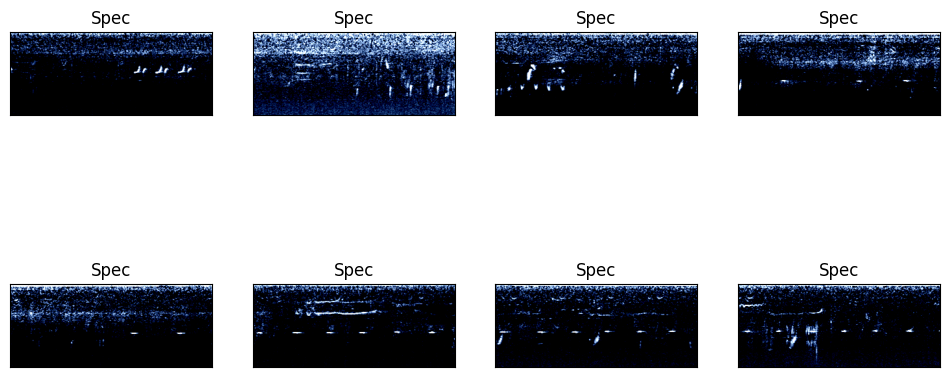

In [8]:
show_batch_soundscape(test_dataset, 8, 2, 4)

## Load model

In [10]:
import timm

In [11]:
class Mel_Classifier(torch.nn.Module):
    def __init__(self, model_name, num_classes = 264, pretrained = True):
        super().__init__()
        self.num_classes = num_classes

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if 'res' in model_name:
            self.in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(self.in_features, num_classes)
        elif 'dense' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Linear(self.in_features, num_classes)
        elif 'efficientnet' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Sequential(
                nn.Linear(self.in_features, num_classes)
            )

    def forward(self,x):
        x = self.backbone(x)
        return x

In [12]:
# Create model instance
network = Mel_Classifier(model_name=CONFIG.model_name, pretrained=False)

# Load weights
network.load_state_dict(torch.load(CONFIG.pretrained_weights, map_location=CONFIG.device))

# Set to eval
network.eval()

/home/colin/elec5305/ele5305_research_project/.venv/lib/python3.11/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 10a7092c-24fc-4dfc-b8f8-1b74f1363dcd)')' thrown while requesting HEAD https://huggingface.co/timm/tf_efficientnet_b0.ns_jft_in1k/resolve/main/model.safetensors


Mel_Classifier(
  (backbone): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), st

## Define Evaluation Function

In [13]:

def padded_cmap(solution, submission, padding_factor=5):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

In [14]:
# Get species list
df_all = pd.read_csv(CONFIG.metadata_path)
species_list = list(set(df_all['primary_label']))

## Make Predicitons

In [15]:
toProbs = torch.nn.Softmax(dim=1)

outputs = [0] * len(test_dataset)

for i in range(len(test_dataset)):
    pred = toProbs(network(test_dataset[i]['mel_specs'])).detach().cpu().numpy()

    outputs[i] = pred

## Make Submission

In [16]:
filenames = df_test.filename.values.tolist()
sub_df = pd.DataFrame(columns=['row_id']+species_list)

for i, file in enumerate(filenames):
    pred = outputs[i]
    num_rows = pred.shape[0]

    row_ids = [f'{file}_{(i+1)*5}' for i in range(num_rows)]
    df = pd.DataFrame(columns=['row_id']+species_list)
    
    df['row_id'] = row_ids


    df[species_list] = pred

    sub_df = pd.concat([sub_df,df]).reset_index(drop=True)


/tmp/ipykernel_7875/1072337811.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sub_df = pd.concat([sub_df,df]).reset_index(drop=True)


In [17]:
csv_path = os.path.join(CONFIG.outpath, 'submission.csv')
sub_df.to_csv(csv_path,index=False)